In [1]:
from helpers import lemmatize_stemming, preprocess
import pandas as pd
from pprint import pprint
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
np.random.seed(2018)
nltk.download('wordnet')

filenames = !ls data/unzipped
filenames = [ 'data/unzipped/'+filename for filename in filenames ]


/home/adrien/twitter-analysis/nlpenv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to /home/adrien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import random
indeces = random.sample(range(len(filenames)), 10)
indeces

[89, 208, 175, 260, 85, 420, 409, 424, 59, 255]

In [3]:
from helpers import load_tweets

documents = pd.DataFrame(load_tweets(np.array(filenames)[indeces]))

print(len(documents))
print(documents[:5])
documents[0].iloc[2]


8117
                                                   0
0  Coronavirus pandemic misery expected to last t...
1  These are unprecedented times for all of us, i...
2  THREAD: Channel 5 controller Ben Frow is curre...
3  @Soren56121222 @gD6WEjY1kzjdBub @RStivaletti @...
4  Today Scotland has reported 301 new infections...


'THREAD: Channel 5 controller Ben Frow is currently giving a live Q&amp;A on how the Coronavirus Pandemic has impacted production and programming for Channel 5. \n\nHighlights from the #EdTVFest will be posted in a thread below... 👇'

In [4]:
doc_sample = documents[0].iloc[311]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

processed_docs = documents[0].map(preprocess)
# processed_docs = documents.map(preprocess) ?
processed_docs[:10]

original document: 
['These', 'are', 'frightening', 'times', 'but', 'there', 'is', 'so', 'much', 'hope', 'and', 'reasons', 'to', 'feel', 'uplifted.', 'These', 'stories', 'of', '#frontline', 'workers', 'are', 'inspiring', 'and', 'heroic,', 'the', 'type', 'of', 'humans', 'we', 'all', 'should', 'aspire', 'to', 'be.', '#COVID19', '#EMS', 'https://t.co/ouLTraE9bs']


 tokenized and lemmatized document: 
['frighten', 'time', 'hope', 'reason', 'feel', 'uplift', 'stori', 'frontlin', 'worker', 'inspir', 'heroic', 'type', 'human', 'aspir', 'covid', 'https', 'oultra']


0    [coronavirus, pandem, miseri, expect, year, sa...
1    [unpreced, time, includ, children, sure, fact,...
2    [thread, channel, control, frow, current, give...
3    [soren, weji, kzjdbub, rstivaletti, washington...
4    [today, scotland, report, infect, total, death...
5    [watch, virtual, govern, webinar, topic, cover...
6    [peopl, rebel, like, june, michigan, whitmer, ...
7    [morgan, take, issu, comment, fellow, democrat...
8    [peopl, get, coronavirus, maryland, virginia, ...
9    [interest, articl, latest, drive, trend, allst...
Name: 0, dtype: object

In [5]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print(list(dictionary.items())[:10])

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
len([t for t in bow_corpus if t])

[(0, 'colleg'), (1, 'coronavirus'), (2, 'decis'), (3, 'expect'), (4, 'expert'), (5, 'forese'), (6, 'futur'), (7, 'https'), (8, 'iprhrtbg'), (9, 'miseri')]


8023

In [6]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], dictionary[bow_doc_4310[i][0]], bow_doc_4310[i][1]))

Word 40 ("keep") appears 1 time.
Word 64 ("like") appears 1 time.
Word 235 ("look") appears 1 time.
Word 457 ("home") appears 1 time.


In [7]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3829387174991539),
 (1, 0.3465298350462343),
 (2, 0.31545433243641774),
 (3, 0.3019731333474637),
 (4, 0.29777021630123973),
 (5, 0.21666184481642178),
 (6, 0.3134197780545493),
 (7, 0.24627822519822024),
 (8, 0.22371682050377645),
 (9, 0.17738496802266265),
 (10, 0.33394703448558893),
 (11, 0.23461918133437407)]


In [8]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=10, workers=4, alpha=0.01, eta=.91)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"covid" + 0.018*"trump" + 0.015*"test" + 0.015*"death" + 0.014*"case" + 0.012*"say" + 0.009*"china" + 0.007*"report" + 0.007*"pandem" + 0.007*"health"
Topic: 1 
Words: 0.021*"covid" + 0.017*"lockdown" + 0.016*"pandem" + 0.014*"peopl" + 0.008*"help" + 0.008*"work" + 0.008*"home" + 0.007*"busi" + 0.007*"time" + 0.007*"news"


In [9]:
import numpy as np
import tqdm
from helpers import compute_coherence_values


grid = {}
grid['Validation_Set'] = {}# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')# Validation sets
alpha = ['symmetric']
beta = [.91]
num_of_docs = len(bow_corpus)
bow_corpus_sets = [# gensim.utils.ClippedCorpus(bow_corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(bow_corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(bow_corpus, int(num_of_docs*0.75)), 
               bow_corpus]
bow_corpus_title = ['75% bow_corpus', '100% bow_corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation bow_corpuses
    for i in range(len(bow_corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=bow_corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(bow_corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)

    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  3%|▎         | 18/540 [01:11<34:33,  3.97s/it]


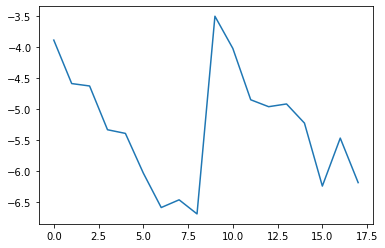

In [10]:
import matplotlib.pyplot as plt

plt.plot(model_results['Coherence'])

In [11]:
res = pd.DataFrame(model_results)
coh = np.array(model_results['Coherence'])
np.argmax(coh)
# res.iloc[270:300]

9

In [12]:
res.iloc[9]

Validation_Set    100% bow_corpus
Topics                          2
Alpha                   symmetric
Beta                         0.91
Coherence               -3.497051
Name: 9, dtype: object